In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [4]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [5]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [6]:
target_house = '오피스텔'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:00, 35.26it/s]


(179297, 11)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0


In [7]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [8]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [9]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [10]:
print(house_merge_df.shape)

(177052, 19)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '영등포구'
target_dong = '당산동'
target_purpose = '준공업'
target_building_age = 5
target_period = 18 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'].str.contains(target_dong))
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(155, 21)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
165030,서울특별시 영등포구 당산동 121-109,국회대로55길 26,하임4 S,59.56,33000,5,2016.0,4.0,2020-12-18,554.063130,5.0,대,364.0,준주거지역,지정되지않음,주상기타,평지,정방형,세로각지(가),영등포구,당산동
167374,서울특별시 영등포구 당산동1가 140-1,영신로43길 17,현대가우스빌,34.09,35000,2,2016.0,5.0,2021-01-06,1026.694045,5.0,대,107.4,준공업지역,지정되지않음,주상용,평지,사다리형,소로각지,영등포구,당산동1가
169472,서울특별시 영등포구 당산동6가 280-10,당산로50길 10,위너스하임,36.04,29000,8,2017.0,3.0,2020-12-31,804.661487,4.0,공장용지,438.3,준공업지역,지정되지않음,주거기타,평지,부정형,세로각지(가),영등포구,당산동6가
169473,서울특별시 영등포구 당산동6가 280-10,당산로50길 10,위너스하임,36.04,32850,6,2017.0,4.0,2021-04-10,911.487236,4.0,공장용지,438.3,준공업지역,지정되지않음,주거기타,평지,부정형,세로각지(가),영등포구,당산동6가
172492,서울특별시 영등포구 당산동 121-75,버드나루로19길 8,소미골드라인III,37.86,27200,5,2019.0,0.0,2019-12-23,718.436344,2.0,대,478.0,준주거지역,지정되지않음,주상기타,평지,사다리형,소로한면,영등포구,당산동


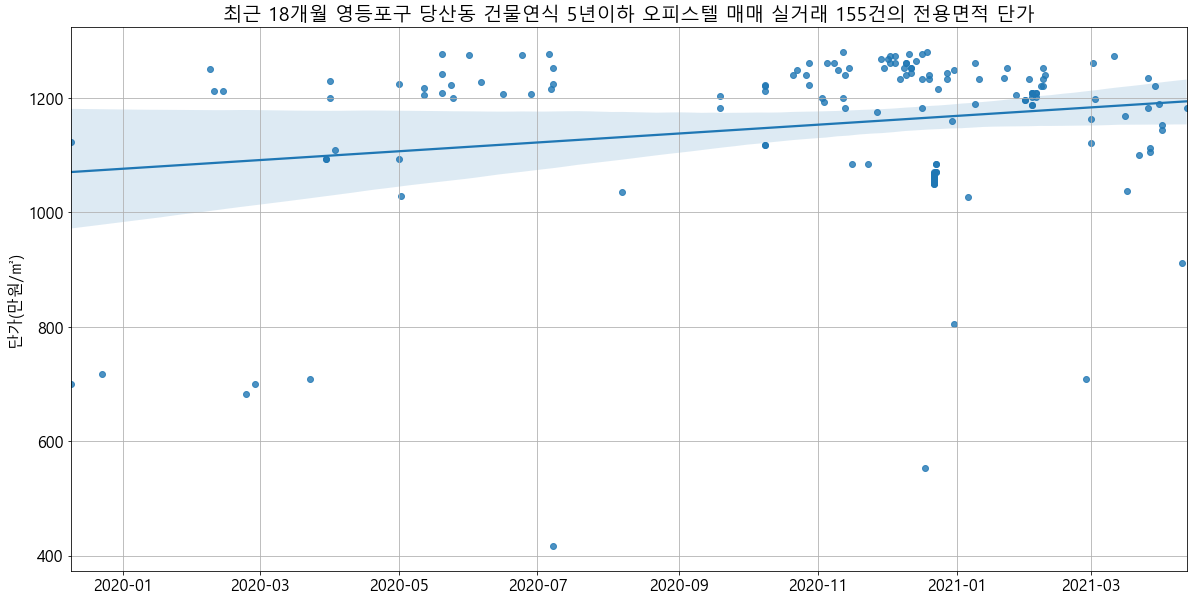

In [14]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_산포도.png'.format(target_gu, target_dong, target_house))

In [27]:
concat_df = pd.concat([target_df]).sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)

In [28]:
concat_df

,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
0,서울특별시 영등포구 당산동 121-109,국회대로55길 26,하임4 S,59.56,33000,5,2016.0,4.0,2020-12-18,554.063130,5.0,대,364.0,준주거지역,지정되지않음,주상기타,평지,정방형,세로각지(가),영등포구,당산동
1,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,23.14,24750,4,2020.0,0.0,2020-12-22,1069.576491,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동
2,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,22.75,24100,3,2020.0,0.0,2020-12-22,1059.340659,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동
3,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,22.75,24100,3,2020.0,0.0,2020-12-22,1059.340659,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동
4,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,22.88,24400,3,2020.0,0.0,2020-12-22,1066.433566,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동
5,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,23.14,24600,3,2020.0,0.0,2020-12-22,1063.094209,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동
6,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,23.14,24300,2,2020.0,0.0,2020-12-22,1050.129646,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동
7,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,22.88,24000,2,2020.0,0.0,2020-12-22,1048.951049,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동
8,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,22.75,23900,2,2020.0,0.0,2020-12-22,1050.549451,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동
9,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,22.88,24250,3,2020.0,0.0,2020-12-22,1059.877622,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동


In [17]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']

In [18]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(155, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,단가평균
0,서울특별시 영등포구 당산동 121-109,국회대로55길 26,하임4 S,59.56,33000,5,2016.0,4.0,2020-12-18,554.063130,5.0,대,364.0,준주거지역,지정되지않음,주상기타,평지,정방형,세로각지(가),영등포구,당산동,554.063130
1,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,23.14,24750,4,2020.0,0.0,2020-12-22,1069.576491,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동,1107.290062
2,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,22.75,24100,3,2020.0,0.0,2020-12-22,1059.340659,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동,1107.290062
3,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,22.75,24100,3,2020.0,0.0,2020-12-22,1059.340659,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동,1107.290062
4,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,22.88,24400,3,2020.0,0.0,2020-12-22,1066.433566,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동,1107.290062


In [19]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(17, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,단가평균
0,서울특별시 영등포구 당산동 121-109,국회대로55길 26,하임4 S,59.56,33000,5,2016.0,4.0,2020-12-18,554.063130,5.0,대,364.0,준주거지역,지정되지않음,주상기타,평지,정방형,세로각지(가),영등포구,당산동,554.063130
27,서울특별시 영등포구 당산동 121-163,버드나루로15길 9,신현빌5차,22.75,27500,5,2020.0,1.0,2021-02-05,1208.791209,1.0,대,202.0,준주거지역,지정되지않음,주상용,평지,세로장방,소로한면,영등포구,당산동,1107.290062
37,서울특별시 영등포구 당산동 121-261,버드나루로 144,오피디움,26.40,29500,4,2019.0,1.0,2020-10-09,1117.424242,2.0,대,321.0,일반상업지역,제2종일반주거지역,업무용,평지,세로장방,중로한면,영등포구,당산동,1155.065945
38,서울특별시 영등포구 당산동 121-75,버드나루로19길 8,소미골드라인III,37.86,27200,5,2019.0,0.0,2019-12-23,718.436344,2.0,대,478.0,준주거지역,지정되지않음,주상기타,평지,사다리형,소로한면,영등포구,당산동,718.436344
39,서울특별시 영등포구 당산동1가 140-1,영신로43길 17,현대가우스빌,34.09,35000,2,2016.0,5.0,2021-01-06,1026.694045,5.0,대,107.4,준공업지역,지정되지않음,주상용,평지,사다리형,소로각지,영등포구,당산동1가,1026.694045
40,서울특별시 영등포구 당산동1가 144-0,,블리스다임빌,29.22,30287,3,2017.0,3.0,2020-08-07,1036.516085,4.0,대,166.2,준공업지역,지정되지않음,주상용,평지,사다리형,소로한면,영등포구,당산동1가,1036.516085
41,서울특별시 영등포구 당산동1가 186-105,영신로43길 8-16,파비앵 104동,64.78,27000,2,2018.0,2.0,2020-07-08,416.795307,3.0,대,195.0,준공업지역,지정되지않음,주거기타,평지,가로장방,세로한면(가),영등포구,당산동1가,416.795307
43,서울특별시 영등포구 당산동1가 256-8,,퍼스트빌리지,45.86,32500,2,2018.0,2.0,2020-03-23,708.678587,3.0,대,188.0,준공업지역,지정되지않음,다세대,평지,사다리형,세로한면(가),영등포구,당산동1가,695.224546
49,서울특별시 영등포구 당산동1가 260-0,양산로 142,더채움오피스텔,27.94,29900,9,2020.0,0.0,2020-12-23,1070.150322,1.0,대,876.3,준공업지역,지정되지않음,업무용,평지,부정형,중로각지,영등포구,당산동1가,1079.694584
117,서울특별시 영등포구 당산동3가 395-12,당산로33길 21,해라톤,24.99,28600,2,2020.0,1.0,2021-04-01,1144.457783,1.0,대,199.7,준공업지역,지정되지않음,주거기타,평지,부정형,소로각지,영등포구,당산동3가,1227.929106


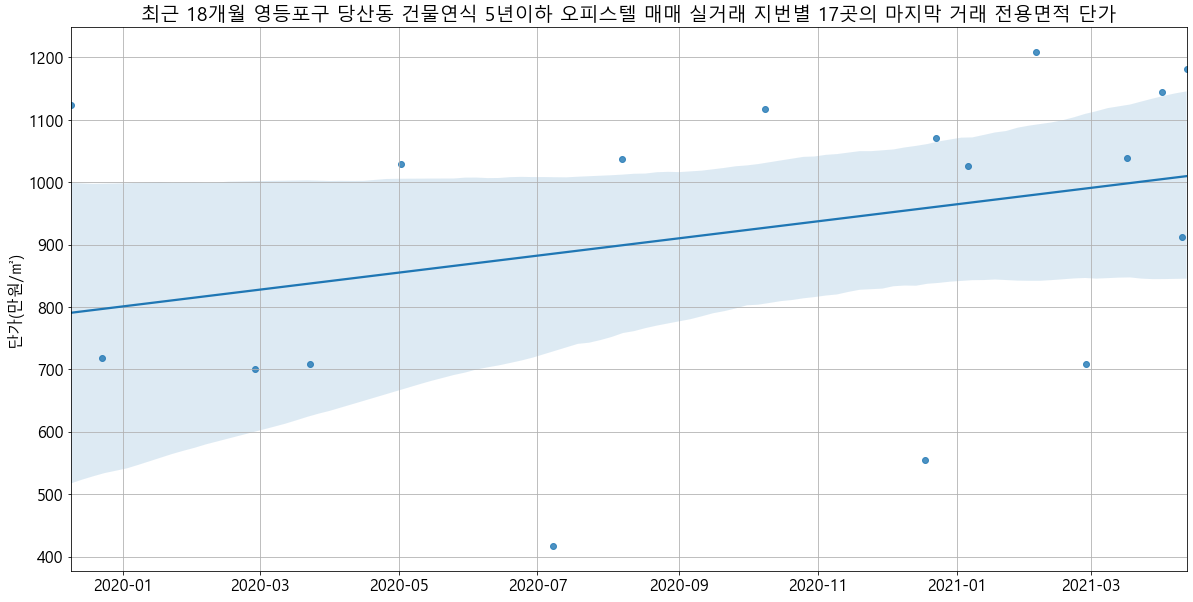

In [20]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(concat_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(concat_last_df['계약날짜']), y=concat_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_산포도.png'.format(target_gu, target_dong, target_house))

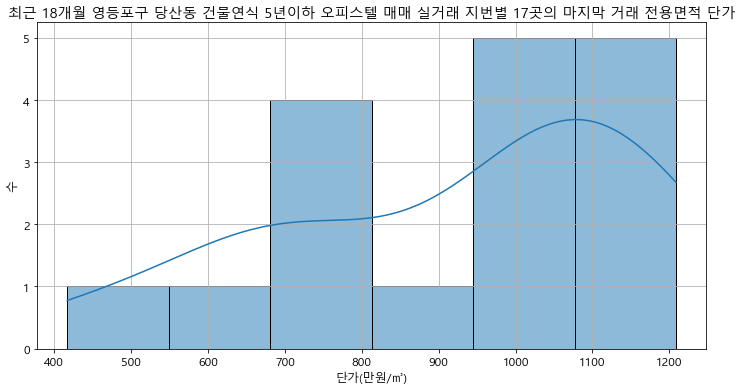

<Figure size 432x288 with 0 Axes>

In [21]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.grid(True)
plt.ylabel('수')
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
sns.histplot(concat_last_df['단가(만원/㎡)'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house))
plt.show()
plt.clf()

In [22]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [23]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '계약날짜', '단가(만원/㎡)', '용도지역명1']]
concat_last_df

,지번주소,건물(단지)명,건축년도,계약날짜,단가(만원/㎡),용도지역명1
0,서울특별시 영등포구 당산동 121-109,하임4 S,2016.0,2020-12-18,554.063130,준주거지역
1,서울특별시 영등포구 당산동 121-163,신현빌5차,2020.0,2021-02-05,1208.791209,준주거지역
2,서울특별시 영등포구 당산동 121-261,오피디움,2019.0,2020-10-09,1117.424242,일반상업지역
3,서울특별시 영등포구 당산동 121-75,소미골드라인III,2019.0,2019-12-23,718.436344,준주거지역
4,서울특별시 영등포구 당산동1가 140-1,현대가우스빌,2016.0,2021-01-06,1026.694045,준공업지역
5,서울특별시 영등포구 당산동1가 144-0,블리스다임빌,2017.0,2020-08-07,1036.516085,준공업지역
6,서울특별시 영등포구 당산동1가 186-105,파비앵 104동,2018.0,2020-07-08,416.795307,준공업지역
7,서울특별시 영등포구 당산동1가 256-8,퍼스트빌리지,2018.0,2020-03-23,708.678587,준공업지역
8,서울특별시 영등포구 당산동1가 260-0,더채움오피스텔,2020.0,2020-12-23,1070.150322,준공업지역
9,서울특별시 영등포구 당산동3가 395-12,해라톤,2020.0,2021-04-01,1144.457783,준공업지역


In [24]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house), index=False)